# How unique are the messages? The analysis below is for the entire population while the next file is for types of organizations.
#### Are they mostly unique? Or usually people are just copy-pasting the same text?
#### You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
#### Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)
#### Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [2]:
!pip uninstall -y nltk



Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4


In [3]:
pip install -U nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 54.6 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
import os
import shutil
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
tweets_spark = spark.read.parquet('gs://' + 'msca-bdp-students-bucket' + '/shared_data/sanchit/tweetsonemillion')


In [6]:
tweets_spark.columns
#confirmation

['created_at',
 'statuses_count',
 'retweeted',
 'text',
 'user_id',
 'username',
 'user_desc',
 'followers_count',
 'location',
 'verified_user']

In [7]:
tweets_spark_limit = tweets_spark.limit(5000)

In [8]:
from pyspark.sql import functions as F


In [9]:
textdf = tweets_spark_limit.select(F.substring('text',1,50).alias("text"))
textdf.limit(5)

text
@PoliticsInsider ...
"RT @edutopia: ""Em..."
#Students in @Peo...
RT @raaahulpandey...
RT @Mr_AlmondED: ...


In [10]:
body_text = textdf.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = body_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [11]:
row = Row('text')
text_df = body_text.map(row).zipWithIndex().toDF(['text','id'])

In [12]:
text_df.limit(5)

text,id
{@PoliticsInsider...,0
"{RT @edutopia: ""E...",1
{#Students in @Pe...,2
{RT @raaahulpande...,3
{RT @Mr_AlmondED:...,4


In [13]:
text_df.count()

5000

In [14]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[@politicsinsider, i’m, gen, with, no, student, debt, an]",0
1,"[rt, @edutopia:, ""emotion, and, learning, are, completely]",1
2,"[#students, in, @peoriaunified11, edcamp, #students, do]",2
3,"[rt, @raaahulpandey:, #shahrukhkhan, के, नाम, पर, मिल, रही]",3
4,"[rt, @mr_almonded:, as, the, new, academic, year, draws, cl]",4


### Step 2. Fit countvectorizer to create word features

In [15]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [16]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[@politicsinsider, i’m, gen, with, no, student, debt, an]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rt, @edutopia:, ""emotion, and, learning, are, completely]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[#students, in, @peoriaunified11, edcamp, #students, do]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @raaahulpandey:, #shahrukhkhan, के, नाम, पर, मिल, रही]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @mr_almonded:, as, the, new, academic, year, draws, cl]",4,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table


In [17]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [18]:
df_hashed_text = text_df.join(df_hashed, "id", how = 'left') 
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
26,{RT @ProfeDeAngel...,"[rt, @profedeange...","(9478,[0,135,145,...","[[4.7945584E7], [..."
29,{RT @SickLitChick...,"[rt, @sicklitchic...","(9478,[0,17,30,87...","[[4.7945584E7], [..."
474,{Final games are ...,"[final, games, ar...","(9478,[1,6,10,11,...","[[6.46399836E8], ..."
964,{@paulg If top co...,"[@paulg, if, top,...","(9478,[30,210,409...","[[1.68051066E8], ..."
1677,{RT @narendramodi...,"[rt, @narendramod...","(9478,[0,1,4,33,4...","[[1.8678956E7], [..."


In [19]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            F.col("distCol"),
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col('datasetA.text').alias('text_A'),
            F.col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

df_dups_30 = df_dups_text

In [20]:
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,2080,2109,"(RT @Jennyfurfuls: Apparently, Sunak is promising ,)","(RT @Jennyfurfuls: Apparently, Sunak is promising ,)"
1,0.0,1198,2148,"(RT @__kiptoo: Best graduating student -class of 20,)","(RT @__kiptoo: Best graduating student -class of 20,)"
2,0.0,115,169,"(RT @LakotaMan1: Starting the fall semester, Native,)","(RT @LakotaMan1: Starting the fall semester, Native,)"
3,0.0,1760,3797,"(RT @Oludeewon: As promised, here is a list of scho,)","(RT @Oludeewon: As promised, here is a list of scho,)"
4,0.0,1195,1249,"(@reaIDonJTrump2 It's the NEXT BIG THING. Economies,)","(@reaIDonJTrump2 It's the NEXT BIG THING. Economies,)"


In [21]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate text based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique text based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5000
Duplicate text based on { 0.3 } jaccard distance:  1362
Unique text based on { 0.3 } jaccard distance:  0.3 :  3638


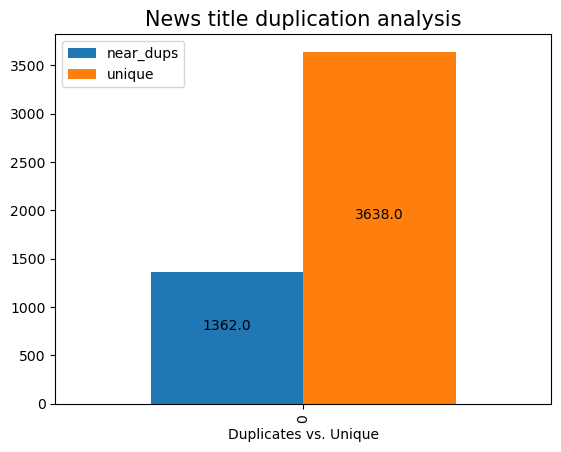

In [22]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [23]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [24]:
df_dups_50 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,1306,1632,"(RT @narendramodi: The PM-SHRI schools will have a ,)","(RT @narendramodi: The PM-SHRI schools will have a ,)"
1,0.3,1775,4231,"(RT @AbrahamOkah2: Apply to these Schools in the US,)","(RT @AbrahamOkah2: Apply to these Schools in Canada,)"
2,0.0,3708,3766,"(RT @annesiaxo: God is soo good! I got accepted int,)","(RT @annesiaxo: God is soo good! I got accepted int,)"
3,0.0,1874,3296,"(RT @BeckettUnite: Our 18 year olds leaving school ,)","(RT @BeckettUnite: Our 18 year olds leaving school ,)"
4,0.0,1611,1642,"(RT @narendramodi: The National Education Policy ha,)","(RT @narendramodi: The National Education Policy ha,)"


In [25]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5000
Duplicate titles based on { 0.5 } jaccard distance:  1486
Unique titles based on { 0.5 } jaccard distance:  0.5 :  3514


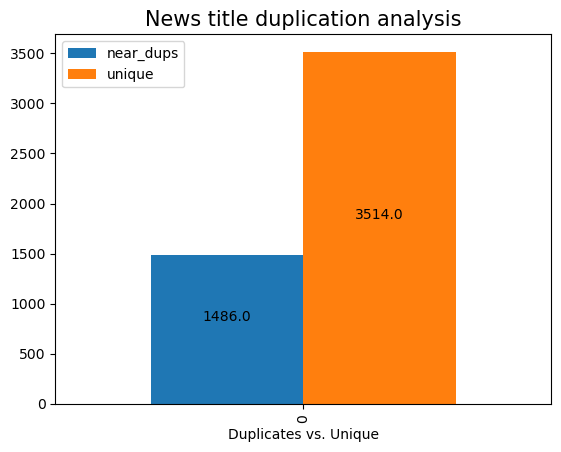

In [26]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [27]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [28]:
df_dups_70 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.666667,14,1171,"(RT @adejimiadeniji: University of Melbourne Jack K,)","(RT @ScholarshipBuc1: University of Milan Excellenc,)"
1,0.333333,1324,1393,"(RT @Insanrohit2515: Education must be play a vital,)","(RT @insan1715: Education must be play a vital role,)"
2,0.666667,920,4157,"(The U.S. Department of Education announced it is d,)","(@EngrABIDHAYAT1 It is available in the website of ,)"
3,0.666667,764,4330,"(RT @NRO: If the Department of Education actually p,)","(RT @msisodia: The job of Education Minister is the,)"
4,0.692308,391,3373,"(RT @RPCAUR: 1158 recruitment is one of the most vi,)","(RT @RamonaBessinger: This is one of thousands of t,)"


In [29]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  5000
Duplicate titles based on { 0.7 } jaccard distance:  1968
Unique titles based on { 0.7 } jaccard distance:  0.7 :  3032


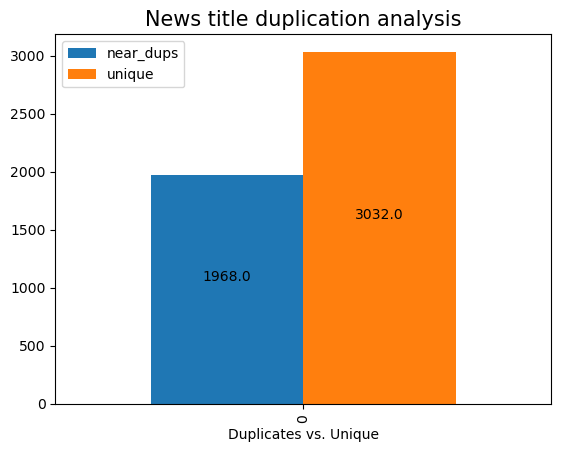

In [30]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Step 5. Compare thresholds side-by-side

#### Select all pairs of duplicate titles across jaccard 


In [31]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

7648


8459


12047


In [32]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
{RT @SIfill_: Jus...,{RT @SIfill_: Jus...,3929,3938,3929,3938,3929,3938
{RT @StrikeDebt: ...,{RT @ToscaAusten:...,443,777,null,null,null,null
{RT @narendramodi...,{RT @narendramodi...,1635,1657,1635,1657,1635,1657
{RT @PolitiFact: ...,{RT @PolitiFact: ...,3140,3153,3140,3153,3140,3153
{RT @narendramodi...,{RT @narendramodi...,1660,1745,1660,1745,1660,1745


In [33]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

text_A,text_B,threshold_30,threshold_50,threshold_70
{RT @Princeujay: ...,{RT @habiba11g: T...,Non-Dup,Non-Dup,Duplicate
{RT @realchrisruf...,{RT @realchrisruf...,Non-Dup,Duplicate,Duplicate
{RT @habiba11g: T...,{RT @shshay_2: Th...,Non-Dup,Duplicate,Duplicate
{RT @HafeezRazaSh...,{RT @HafeezRazaSh...,Non-Dup,Duplicate,Duplicate
{RT @TheDegenU: C...,{RT @LeahRemini: ...,Non-Dup,Non-Dup,Duplicate


#### Select a sample of records across 3 thresholds (jaccard similarities):
* Records that are marked as duplicate by all three thresholds (meet the level of **threshold_30**)
* Records that are identified as non-duplicate by **threshold_30**, while being marked as dups by both **threshold_50** and **threshold_70**
* Records that are identified as non-duplicate by both **threshold_30** and **threshold_50**, while being marked as dups by **threshold_70**

In [34]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [35]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(RT @NoLieWithBTC: NEW: Betsy DeVos just called for,)","(RT @NoLieWithBTC: NEW: Betsy DeVos just called for,)",Duplicate,Duplicate,Duplicate
1,"(RT @narendramodi: The National Education Policy ha,)","(RT @narendramodi: The National Education Policy ha,)",Duplicate,Duplicate,Duplicate
2,"(RT @bmay: Liz is a Conservative now because she sa,)","(RT @bmay: Liz is a Conservative now because she sa,)",Duplicate,Duplicate,Duplicate
3,"(RT @bmay: Liz is a Conservative now because she sa,)","(RT @bmay: Liz is a Conservative now because she sa,)",Duplicate,Duplicate,Duplicate
4,"(RT @DashDobrofsky: Betsy DeVos said she wants to a,)","(RT @DashDobrofsky: Betsy DeVos said she wants to a,)",Duplicate,Duplicate,Duplicate
5,"(RT @kirawontmiss: what the hell are y’all learning,)","(RT @kirawontmiss: what the hell are y’all learning,)",Duplicate,Duplicate,Duplicate
6,"(RT @narendramodi: The National Education Policy ha,)","(RT @narendramodi: The National Education Policy ha,)",Duplicate,Duplicate,Duplicate
7,"(RT @LakotaMan1: Starting the fall semester, Native,)","(RT @LakotaMan1: Starting the fall semester, Native,)",Duplicate,Duplicate,Duplicate
8,"(RT @davido: We have contacted Suleyman who lives i,)","(RT @davido: We have contacted Suleyman who lives i,)",Duplicate,Duplicate,Duplicate
9,"(RT @narendramodi: The National Education Policy ha,)","(RT @narendramodi: The National Education Policy ha,)",Duplicate,Duplicate,Duplicate
